In [2]:
## Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray
import cdsapi
import urllib3
import cartopy.crs as ccrs
import cartopy
from matplotlib.colors import ListedColormap

sys.path.append('..')
from LSD import LSD, BinnedLSD, confidence_interval_from_extreme_regions

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_27221/32150791.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas 

# Prep roi-WBD-NAHL
Create subset version of main data file with only WBD-NAHL ROI lakes.

In [ ]:
df_HL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full.csv.gz'
gdf_HL_jn_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # gives ROI
df_HL_BAWLD_NAHL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full_jnBAWLD_roiNAHL.csv.gz' # Output: main data source # HL clipped to BAWLD and WBD


## Load, if needed
gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')
gdf_roi = gpd.read_file(gdf_HL_jn_pth) # gives indexes of lakes in ROI


/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_41832/3394725772.py:7: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')


In [ ]:
gdf_hl

,Unnamed: 0,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,...,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,system:index,Class_98,Class_99,Class_100
0,0,0.001,0.002,0.000,0.001,0.001,0.000,0.003,0.001,0.248,...,0.0,0.131,50.391481,3.0,Canada,NaN,001b0000000000004e0d,NaN,NaN,NaN
1,1,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.005,0.253,...,0.0,3.071,50.121770,3.0,Canada,NaN,001b00000000000051b5,NaN,NaN,NaN
2,2,0.003,0.000,0.000,0.001,0.001,0.001,0.000,0.003,0.363,...,0.0,0.005,50.490288,3.0,Canada,NaN,001b0000000000004c9d,NaN,NaN,NaN
3,3,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.109,...,0.0,0.001,50.485042,3.0,Canada,NaN,001b0000000000004cb5,NaN,NaN,NaN
4,4,0.001,0.000,0.001,0.001,0.000,0.000,0.003,0.003,0.154,...,0.0,0.001,50.357718,3.0,Canada,NaN,001b0000000000004e80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112147,1112147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374,...,0.0,0.000,79.639685,3.0,Russia,NaN,001f0000000000008301,NaN,NaN,NaN
1112148,1112148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480,...,0.0,-9999.000,79.627083,3.0,Russia,NaN,001f0000000000008305,NaN,NaN,NaN
1112149,1112149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.236,...,0.0,0.695,79.532163,3.0,Russia,NaN,001f00000000000079b8,NaN,NaN,NaN
1112150,1112150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683,...,0.0,2.251,79.580108,3.0,Russia,NaN,001f000000000000830d,NaN,NaN,NaN


In [ ]:
gdf_roi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 754832 entries, 0 to 754831
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Hylak_id    754832 non-null  int64   
 1   0-5         754832 non-null  float64 
 2   5-50        754832 non-null  float64 
 3   50-95       754832 non-null  float64 
 4   95-100      754832 non-null  float64 
 5   Class_sum   754832 non-null  float64 
 6   Shp_Area    754832 non-null  float64 
 7   BAWLDCell_  754832 non-null  int64   
 8   n           754832 non-null  int64   
 9   distance    754832 non-null  float64 
 10  feature_x   754832 non-null  float64 
 11  feature_y   754832 non-null  float64 
 12  nearest_x   754832 non-null  float64 
 13  nearest_y   754832 non-null  float64 
 14  BAWLDLong   754832 non-null  float64 
 15  BAWLDLat    754832 non-null  float64 
 16  geometry    754832 non-null  geometry
dtypes: float64(13), geometry(1), int64(3)
memory usage: 97.9 MB

In [ ]:
gdf_hl = gdf_hl.drop(columns=['Unnamed: 0', 'system:index']).merge(gdf_roi['Hylak_id'], on='Hylak_id', how='inner')

In [ ]:
gdf_hl

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,Class_8,...,Elevation,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,Class_98,Class_99,Class_100
0,0.003,0.000,0.000,0.001,0.001,0.001,0.000,0.003,0.363,0.001,...,621.0,0.0,0.005,50.490288,3.0,Canada,NaN,NaN,NaN,NaN
1,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.109,0.001,...,630.0,0.0,0.001,50.485042,3.0,Canada,NaN,NaN,NaN,NaN
2,0.002,0.000,0.001,0.000,0.001,0.001,0.002,0.001,0.323,0.000,...,613.0,0.0,0.006,50.492419,3.0,Canada,NaN,NaN,NaN,NaN
3,0.005,0.002,0.002,0.001,0.003,0.002,0.000,0.005,0.198,0.002,...,612.0,0.0,0.004,50.498021,3.0,Canada,NaN,NaN,NaN,NaN
4,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.134,0.000,...,624.0,0.0,0.006,50.487126,3.0,Canada,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754827,0.002,0.000,0.000,0.000,0.001,0.002,0.000,0.000,0.164,0.001,...,29.0,0.0,0.037,67.556734,3.0,Canada,NaN,0.000,0.0,0.0
754828,0.000,0.000,0.001,0.001,0.002,0.002,0.000,0.000,0.140,0.001,...,32.0,0.0,0.001,67.528185,3.0,Canada,NaN,0.000,0.0,0.0
754829,0.001,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.103,0.000,...,28.0,0.0,0.001,67.522809,3.0,Canada,NaN,0.000,0.0,0.0
754830,0.000,0.000,0.000,0.003,0.001,0.001,0.000,0.001,0.226,0.000,...,20.0,0.0,0.071,67.637566,3.0,Canada,NaN,0.000,0.0,0.0


In [ ]:
## Write out large file
gdf_hl.to_csv(df_HL_BAWLD_NAHL_jn_full_pth)

# Downing plots

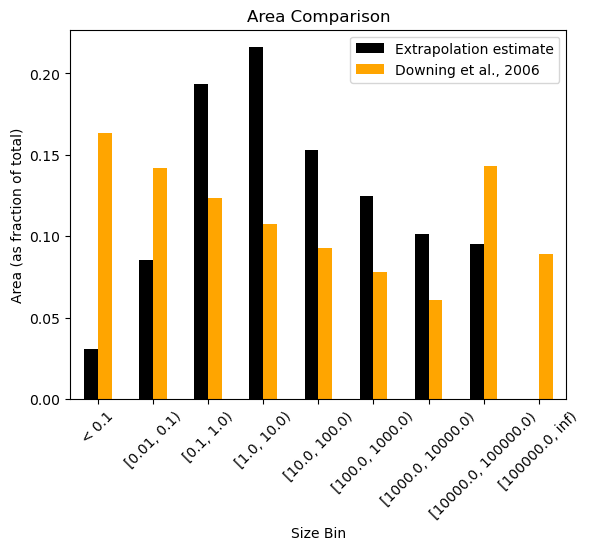

In [3]:
# Load the Excel file
df = pd.read_excel('/Users/ekyzivat/Library/CloudStorage/GoogleDrive-ethan_kyzivat@alumni.brown.edu/My Drive/Writing/Ch4/Revision1/Tables/Size_bin_table_norm_v20_Downing_save.xlsx', sheet_name='comb_bins', index_col='size_bin')

# Exclude the last row with index 'Sum'
df = df.iloc[:-1]

# Define custom colormap with black and orange
colors = ['black', 'orange']
custom_cmap = ListedColormap(colors)

# Plot the 'Area_Mkm2' and 'Downing Area norm'
fig, ax = plt.subplots()
df[['Area_Mkm2', 'Downing Area norm']].plot(kind='bar', colormap=custom_cmap, ax=ax)

# Set labels and title
ax.set_xlabel('Size Bin')
ax.set_ylabel('Area (as fraction of total)')
plt.xticks(rotation=45)
plt.title('Area Comparison')

# plt.legend(['My Arctic estimate', 'Conventional global estimate'])
plt.legend(['Extrapolation estimate', 'Downing et al., 2006'])

# Show the plot
plt.show()


# Compare to PLD global data!

In [3]:
lsd = LSD.from_shapefile('/Volumes/thebe/Other/SWOT-PLD/v0.1/SWOT_PLD.gdb', name='PLD', area_var='ref_area', idx_var='lake_id', _areaConversionFactor=100, other_vars=['lon','lat'])
lsd

,idx_PLD,lat,lon,Area_km2,Region
0,1.110000e+09,14.953211,40.516084,0.0153,PLD
1,1.110000e+09,14.950827,40.513709,0.0207,PLD
2,1.110000e+09,14.963724,40.366773,0.0225,PLD
3,1.110000e+09,16.668554,39.142489,0.0468,PLD
4,1.110000e+09,15.681782,39.445854,0.2423,PLD
...,...,...,...,...,...
5988466,9.140034e+09,80.862147,-22.730605,1.3988,PLD
5988467,9.140034e+09,80.346736,-20.933465,1.7672,PLD
5988468,9.140034e+09,80.324070,-20.940275,1.2997,PLD
5988469,9.140034e+09,80.248108,-21.316198,1.9816,PLD


In [4]:
## Verify min area
lsd.Area_km2.min()
lsd.Area_km2.max()

82220.4017

In [6]:
## Bin
log_bins_upper = [0.1, 1, 10, 100, 1000, 10000, 100000, np.inf]
# now, bin upper values for Table estimate, use regions as placeholder to get dummy CI
lsd_binned = BinnedLSD(lsd, bins=log_bins_upper, compute_ci_lsd=False,
                                    compute_ci_lev=False, compute_ci_lev_existing=True, normalize=False)

/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/LSD/notebooks/../LSD.py:1645: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sums = lsd.groupby(['size_bin']).Area_km2.sum(
/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/LSD/notebooks/../LSD.py:1648: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = lsd.groupby(['size_bin']).Area_km2.count()
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [7]:
## Loading from CIR gdf
print('Load HR...')
regions = ['Sagavanirktok River', 'Yukon Flats Basin', 'Old Crow Flats', 'Mackenzie River Delta',
            'Mackenzie River Valley', 'Canadian Shield Margin', 'Canadian Shield', 'Slave River',
            'Peace-Athabasca Delta', 'Athabasca River', 'Prairie Potholes North',
            'Prairie Potholes South', 'Tuktoyaktuk Peninsula', 'All']
lsd_cir = LSD.from_shapefile('/Volumes/thebe/Planet-SR-2/Classification/cir/dcs_fused_hydroLakes_buf_10_sum.shp',
                                area_var='Area', name='CIR', region_var='Region4', regions=regions, idx_var='OID_')

## Loading PeRL LSD
perl_exclude = ['arg0022009xxxx', 'fir0022009xxxx', 'hbl00119540701', 'hbl00119740617',
                'hbl00120060706', 'ice0032009xxxx', 'rog00219740726', 'rog00220070707',
                'tav00119630831', 'tav00119750810', 'tav00120030702', 'yak0012009xxxx',
                'bar00120080730_qb_nplaea.shp']
lsd_perl = LSD.from_paths('/Volumes/thebe/PeRL/PeRL_waterbodymaps/waterbodies/*.shp',
                            area_var='AREA', name='perl', _areaConversionFactor=1000000, exclude=perl_exclude)

## Loading from Mullen
lsd_mullen = LSD.from_paths('/Volumes/thebe/Other/Mullen_AK_lake_pond_maps/Alaska_Lake_Pond_Maps_2134_working/data/*_3Y_lakes-and-ponds.zip', _areaConversionFactor=1000000,
                            name='Mullen', computeArea=True)  # '/Volumes/thebe/Other/Mullen_AK_lake_pond_maps/Alaska_Lake_Pond_Maps_2134_working/data/[A-Z][A-Z]_08*.zip'

## Combine PeRL and CIR and Mullen
lsd_ref = LSD.concat((lsd_cir, lsd_perl, lsd_mullen),
                    broadcast_name=True, ignore_index=True)
compute_ci_lsd=True
error_bars=True
ref_ds = 'Arctic HR'

Load HR...


In [66]:
## Alternatively, load WBD as ref
print('Load WBD...')
lsd_ref = LSD.from_shapefile(
    '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/fixed_geoms/WBD.shp', area_var='Area', name='WBD', idx_var='OBJECTID')
lsd_ref.truncate(0.001, inplace=True)
compute_ci_lsd=False
error_bars=False
ref_ds = 'WBD'

Load WBD...


In [16]:
## Simple extrap from HR
extreme_regions_lsd = [
    'Tuktoyaktuk Peninsula', 'sur00120130802_tsx_nplaea']

# Truncation limits for ref LSD. tmax defines the right bound of the index region. tmin defines the leftmost bound to extrapolate to.
tmin, tmax = (0.0001, 1)

# Extrapolation limits. emax defines the left bound of the index region (and right bound of the extrapolation region).
emax = 0.05
binned_ref = BinnedLSD(lsd_ref.truncate(tmin, tmax), tmin, emax, compute_ci_lsd=compute_ci_lsd,
                        extreme_regions_lsd=extreme_regions_lsd)  # reference distrib (try 5, 0.5 as second args)
# Beware chaining unless I return a new variable. # Try 0.1
lsd_trunc = lsd.truncate(emax, np.inf)
lsd_trunc.extrapolate(binned_ref)
# meas = lsd_hl_lev.sumAreas(includeExtrap=False)
# extrap = lsd_hl_trunc.sumAreas()

/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/LSD/notebooks/../LSD.py:1645: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sums = lsd.groupby(['size_bin']).Area_km2.sum(
/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/LSD/notebooks/../LSD.py:1648: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = lsd.groupby(['size_bin']).Area_km2.count()
/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/LSD/notebooks/../LSD.py:1655: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Text(0.5, 1.0, 'Extrapolated from Arctic HR')

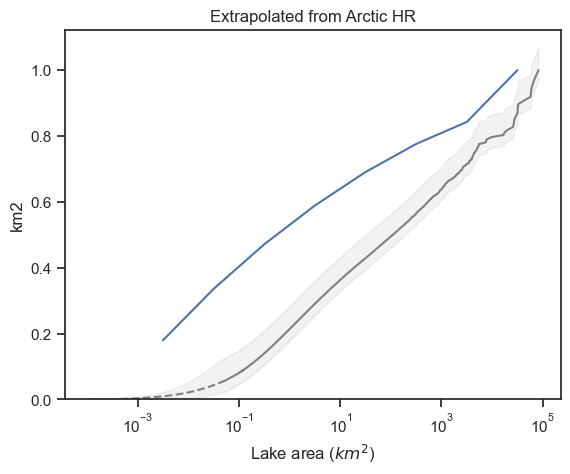

In [17]:
## Put Downing number into my BinnedLSD data structure, just to verify plot
btm = 0.001
top = 100000
nbins = 8
bin_edges = np.concatenate((np.geomspace(btm, top, nbins+1), [np.inf])).round(6) # bins computed from nbins and edges
area_bins = pd.IntervalIndex.from_breaks(bin_edges, closed='left')
X = bin_edges[1:] # plot against right bin edge
d06 = [692600, 602100, 523400, 455100, 392362, 329816, 257856, 607650, 378119]
group_sums = pd.Series(d06, index=area_bins, name='Area_km2') # from Downing 2006 paper
binnedAreas = confidence_interval_from_extreme_regions(group_sums, None, None, name='Area_km2') # # Why are lower/upper non NaN?? Ignore.
lsd_d06 = BinnedLSD(btm=btm, top=top, nbins=nbins, binned_areas=binnedAreas, compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args
# lsd_d06_canon = BinnedLSD(btm=bin_edges[4], top=bin_edges[-2], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[4:-1], None, None, name='Area_km2'), compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args
# lsd_d06_extrap = BinnedLSD(btm=bin_edges[0], top=bin_edges[4], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[:4], None, None, name='Area_km2'), compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args

fig, ax = plt.subplots()
lsd_trunc.plot_extrap_lsd(ax=ax, label='Lake area', error_bars=error_bars, normalized=True, color='grey', plotLegend=False)

lsd_d06.plot(ax=ax, show_rightmost=False, as_lineplot=True, as_cumulative=True) # plot as binnedLSD, skipping top bin with Caspian Sea
plt.xscale('log')
plt.yscale('linear')
plt.title(f'Extrapolated from {ref_ds}')


In [10]:
lsd_trunc.extrapLSD.binnedAreas

size_bin              stat 
[0.0001, 0.000106)    mean       69.825801
                      lower       4.599747
                      upper     120.523077
[0.000106, 0.000113)  mean      114.096790
                      lower       4.946227
                                  ...     
[0.044156, 0.046987)  lower    2567.056139
                      upper    8791.198014
[0.046987, 0.05)      mean     4868.026331
                      lower    1821.642338
                      upper    7946.721023
Name: Area_km2, Length: 300, dtype: float64

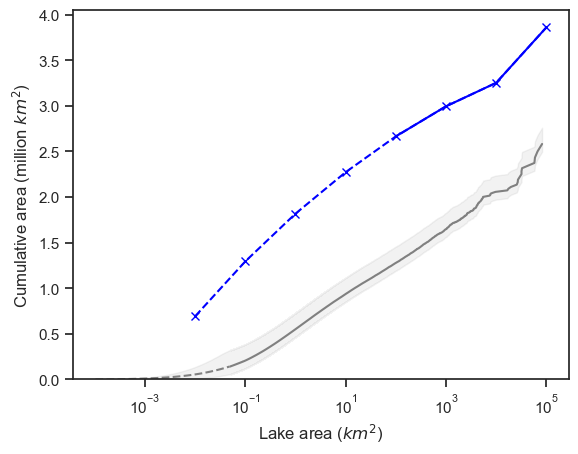

In [18]:
## Second way
fig, ax = plt.subplots()

# ## Put Downing number into my BinnedLSD data structure, just to verify plot
# lsd_d06 = BinnedLSD(btm=btm, top=top, nbins=nbins, binned_areas=binnedAreas, compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args
# # lsd_d06_canon = BinnedLSD(btm=bin_edges[4], top=bin_edges[-2], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[4:-1], None, None, name='Area_km2'), compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args
# # lsd_d06_extrap = BinnedLSD(btm=bin_edges[0], top=bin_edges[4], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[:4], None, None, name='Area_km2'), compute_ci_lsd=False) # give btm, top, nbins, compute_ci_lsd and binnedAreas args
# lsd_d06.plot(ax=ax, show_rightmost=False, as_lineplot=True, as_cumulative=True) # plot as binnedLSD, skipping top bin with Caspian Sea

# ax.plot(X, np.cumsum(d06)/np.sum(d06)) # units Mkm2 /1e6
d06_canonical = d06[4:]
d06_extrap = d06[:4]
ax.plot(X[:-1], np.cumsum(d06[:-1])/1e6, color='blue', marker='x',linestyle='dashed') # This time, exclude top bin to better compare with BAWLD domain # /np.sum(d06[:-1])
ax.plot(X[4:-1], (np.cumsum(d06_canonical[:-1])+np.sum(d06_extrap))/1e6, color='blue') # Plot canonical # /(np.sum(d06_canonical[:-1]) + np.sum(d06_extrap))
# ax.plot(X[:4], np.cumsum(d06_extrap)/np.sum(d06[:-1]), color='orange', linestyle='dashed') # Plot extrap

## Plot WBD
lsd_trunc.plot_extrap_lsd(ax=ax, label='Lake area', error_bars=True, normalized=False, color='grey', plotLegend=False)


ax.set_yscale('linear')
ax.set_xscale('log')
# ax.set_xticks(X)

In [33]:
# Orig area (note Caspian Sea note included in PLD)
lsd.sumAreas(includeExtrap=False) / 1e6

# Orig area (compare to HL size domain)
lsd.truncate(0.1, np.inf).sumAreas(includeExtrap=False) / 1e6
# lsd.area_fraction(0.1)

# Extrap area
# lsd_trunc.sumAreas() / 1e6



2.3760046708825215

# Compare to HL global dataset

In [25]:
## Load HL
lsd_hl = LSD.from_shapefile('/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', name='HL', area_var='Lake_area', idx_var='Hylak_id', _areaConversionFactor=1)

In [28]:
## Compare to HL
lsd_hl.sumAreas(includeExtrap=False) / 1e6

2.92672277

# Compare BAWLD vs HL areas

## Start with Yashwin's BAWLD vs PLD

In [89]:
## Load andf filter Yashwin's shorelines
df_shorelines = gpd.read_file('/Volumes/thebe/Global-lake-shorelines/digitizing/Yashwin/EDK_updated/global_shorelines2023912_edk_lambert.shp', engine='pyogrio', read_geometry=False)
df_shorelines.drop(index=df_shorelines[(df_shorelines.layer != 'BAWLD_lakes') | (df_shorelines.Skipped == 1)].index, inplace=True)
df_shorelines

,ID,STUDY,DATASET,YEAR,COUNTRY,SITE,LAT,LONG,SA,DEPTH,...,ref_wse,Shape_Leng,Shape_Area,Img_src,rownum,dup,EDK_flag,area,perimeter,A_km2_dig
332,320,Phelps et al. 1998,WIK,1998.0,USA,Goose Lake,61.120000,-149.490000,0.2,2.2,...,NaN,NaN,NaN,Google_imagery,333.0,0.0,NaN,1.668801e+05,2589.786545,0.167
337,333,Repo et al. 2007,WIK,2007.0,Canada,FTLake,58.450000,-94.090000,0.07,1.4,...,NaN,NaN,NaN,Google_imagery,338.0,0.0,NaN,5.586612e+04,2912.772065,0.056
357,366,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Grayling,66.950000,-150.390000,0.401,1.8,...,NaN,NaN,NaN,PLD,359.0,NaN,NaN,3.474913e+05,3532.708826,0.347
358,377,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Scout,60.530000,-150.840000,0.384,6.3,...,NaN,NaN,NaN,PLD,361.0,NaN,NaN,2.710235e+05,4045.186762,0.271
359,378,Sepulveda-Jauregui et al. 2015,WIK,2014.0,USA,Swampbuggy,63.060000,-147.420000,0.142,4.9,...,NaN,NaN,NaN,PLD,363.0,NaN,NaN,1.297023e+05,2278.438458,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,227,Kuhn et al. unpublished,KUHN,2020.0,Canada,W1,63.151000,-123.249000,0.042,3.5,...,NaN,NaN,NaN,Google_imagery,738.0,0.0,NaN,3.569225e+04,1699.992164,0.036
734,228,Kuhn et al. unpublished,KUHN,2020.0,Canada,W2,63.151000,-123.249000,0.01,1.1,...,NaN,NaN,NaN,Google_imagery,739.0,0.0,NaN,8.606812e+03,622.662269,0.009
735,229,Kuhn et al. unpublished,KUHN,2020.0,Canada,W3,63.151000,-123.249000,0.005,0.8,...,NaN,NaN,NaN,Google_imagery,740.0,0.0,NaN,2.456315e+03,219.795203,0.002
790,473,Serikova et al. 2019,KUHN,2016.0,Russia,LKh5,63.812778,75.701111,0.008248,0.875,...,-1.000000e+12,0.180292,0.000257,PLD,795.0,0.0,NaN,1.414088e+06,12086.229932,1.414


/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


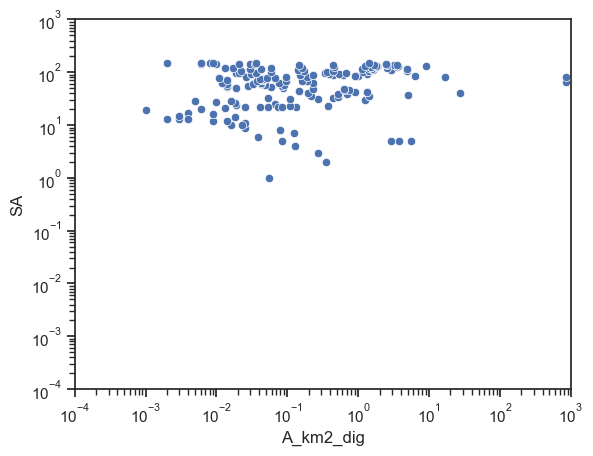

In [91]:
## Plot ## Problem: area are off by orders of magnitude without extra manual filtering... can't show this.
df_shorelines[['A_km2_dig', 'SA']]
sns.scatterplot(df_shorelines, x='A_km2_dig', y='SA')
plt.xlim([0.0001, 1000])
plt.ylim([0.0001, 1000])
plt.xscale('log')
plt.yscale('log')

## Now try with HL vs BAWLD

In [106]:
## Load BAWLD-CH4 joined to HL lakes as shapefile, and preprocess
df_shorelines = gpd.read_file('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/joined-to-hl/bawld-ch4-hl.shp', engine='pyogrio', read_geometry=False)
df_shorelines.replace('-', np.nan, inplace=True)
df_shorelines['SA'] = df_shorelines['SA'].astype('float')
df_shorelines.drop(index=df_shorelines[(df_shorelines['NUMBER.LAK'] !=  '1') | (df_shorelines['SA'] < 0.1)].index, inplace=True)
df_shorelines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 1 to 65
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          42 non-null     int64  
 1   NUM         42 non-null     int64  
 2   STUDY       42 non-null     object 
 3   DATASET     42 non-null     object 
 4   YEAR        42 non-null     int64  
 5   COUNTRY     42 non-null     object 
 6   SITE        42 non-null     object 
 7   NUMBER.LAK  42 non-null     object 
 8   LAT         42 non-null     float64
 9   LONG        42 non-null     float64
 10  ECOREGION   42 non-null     object 
 11  PERMA.ZONE  42 non-null     object 
 12  LAKE.TYPE   42 non-null     object 
 13  BOTTOM      42 non-null     object 
 14  TALIK       30 non-null     object 
 15  SA          40 non-null     float64
 16  DEPTH       37 non-null     object 
 17  SEASON      42 non-null     object 
 18  YEAR.S      42 non-null     object 
 19  MONTH       42 non-null     object 


/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.0, 2.0)

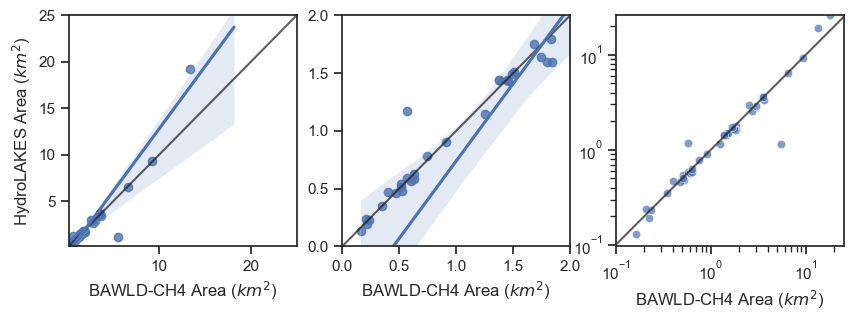

In [128]:
## Plot
fig, ax = plt.subplots(1,3, figsize=(10,3))
lim = [0.1, 25]
for a in ax:
    a.plot([0.000001, 100000], [0.000001, 100000], '-k', alpha=0.7)
    plt.axis('equal')
sns.regplot(df_shorelines, x='SA', y='Lake_area', ax=ax[0]) 
sns.regplot(df_shorelines, x='SA', y='Lake_area', ax=ax[1]) 
sns.scatterplot(df_shorelines, x='SA', y='Lake_area', alpha=0.7, ax=ax[2])

for a in ax:
    a.set_xlabel('BAWLD-CH4 Area ($km^2$)')
    a.set_xlim(lim)
    a.set_ylim(lim)
ax[0].set_ylabel('HydroLAKES Area ($km^2$)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[1].set_xlim([0, 2])
ax[1].set_ylim([0, 2])